<a href="https://colab.research.google.com/github/rsabilio/ia024-projeto-rag/blob/main/4_rag_recursive_retriever.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Instruções

* Estratégia
    * Recursive Retriever
    * Reranker com monoPTT5-large

# Instalando pacotes

In [1]:
!pip install -q llama-index llama-index-llms-groq sentence-transformers llama-index-embeddings-huggingface transformers rerankers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.1/227.1 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.4/15.4 MB 48.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 68.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.8/130.8 kB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 327.4/327.4 kB 34.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 57.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 853.2/853.2 kB 57.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.4/290.4 kB 35.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 56.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━

# Importando pacotes

In [2]:
import os
from google.colab import userdata

os.environ['GROQ_API_KEY'] = userdata.get('GROQ_API_KEY')

In [3]:
from llama_index.core import Settings, VectorStoreIndex, PromptTemplate
from llama_index.embeddings.huggingface import HuggingFaceEmbedding
from llama_index.llms.groq import Groq
from llama_index.core.schema import TextNode, IndexNode
from llama_index.core.node_parser import SentenceSplitter
from llama_index.core.retrievers import RecursiveRetriever
from llama_index.core.query_engine import RetrieverQueryEngine
from llama_index.core.evaluation import FaithfulnessEvaluator, CorrectnessEvaluator, RelevancyEvaluator
from llama_index.core.response.notebook_utils import display_source_node, display_response
from llama_index.core import StorageContext, load_index_from_storage
from rerankers import Reranker

import glob
import json
import pandas as pd
from rich.pretty import pprint
from tqdm import tqdm
from IPython.display import Markdown, display
import shutil
import pickle
import torch

import nest_asyncio
nest_asyncio.apply()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# GitHub

In [4]:
GITHUB_TOKEN      = userdata.get('GITHUB_TOKEN')
GITHUB_USER_EMAIL = userdata.get('GITHUB_USER_EMAIL')
GITHUB_USER_NAME  = userdata.get('GITHUB_USER_NAME')

!git config --global user.email '''{GITHUB_USER_EMAIL}'''
!git config --global user.name '''{GITHUB_USER_NAME}'''

# Clonar o repositório GitHub
!git clone https://{GITHUB_TOKEN}@github.com/rsabilio/ia024-projeto-rag.git

Cloning into 'ia024-projeto-rag'...
remote: Enumerating objects: 9111, done.
remote: Counting objects: 100% (660/660), done.
remote: Compressing objects: 100% (300/300), done.
remote: Total 9111 (delta 458), reused 543 (delta 351), pack-reused 8451
Receiving objects: 100% (9111/9111), 1.27 GiB | 44.92 MiB/s, done.
Resolving deltas: 100% (3979/3979), done.
Updating files: 100% (5818/5818), done.
Filtering content: 100% (1211/1211), 140.28 MiB | 10.68 MiB/s, done.


In [5]:
DATA_DIR = '/content/ia024-projeto-rag'

## Configurando Git para arquivos maiores quem 100MB

In [6]:
!curl -s https://packagecloud.io/install/repositories/github/git-lfs/script.deb.sh | sudo bash

Detected operating system as Ubuntu/jammy.
Checking for curl...
Detected curl...
Checking for gpg...
Detected gpg...
Detected apt version as 2.4.12
Running apt-get update... done.
Installing apt-transport-https... done.
Installing /etc/apt/sources.list.d/github_git-lfs.list...done.
Importing packagecloud gpg key... Packagecloud gpg key imported to /etc/apt/keyrings/github_git-lfs-archive-keyring.gpg
done.
Running apt-get update... done.

The repository is setup! You can now install packages.


In [7]:
!apt-get install git-lfs

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following packages will be upgraded:
  git-lfs
1 upgraded, 0 newly installed, 0 to remove and 47 not upgraded.
Need to get 7,420 kB of archives.
After this operation, 6,051 kB of additional disk space will be used.
Get:1 https://packagecloud.io/github/git-lfs/ubuntu jammy/main amd64 git-lfs amd64 3.5.1 [7,420 kB]
Fetched 7,420 kB in 0s (25.1 MB/s)
(Reading database ... 121929 files and directories currently installed.)
Preparing to unpack .../git-lfs_3.5.1_amd64.deb ...
Unpacking git-lfs (3.5.1) over (3.0.2-1ubuntu0.2) ...
Setting up git-lfs (3.5.1) ...
Git LFS initialized.
Processing triggers for man-db (2.10.2-1) ...


In [8]:
%cd /content/ia024-projeto-rag

!git lfs install
!git lfs track "*.json"
!git add .gitattributes

/content/ia024-projeto-rag
Updated Git hooks.
Git LFS initialized.
"*.json" already supported


In [9]:
%cd /content/ia024-projeto-rag

!git pull origin main
!git add .
!git commit -m "Configurando Git para arquivos maiores"
!git lfs push --all origin main
!git push origin main


/content/ia024-projeto-rag
From https://github.com/rsabilio/ia024-projeto-rag
 * branch            main       -> FETCH_HEAD
Already up to date.
On branch main
Your branch is up to date with 'origin/main'.

nothing to commit, working tree clean
Uploading LFS objects: 100% (593/593), 147 MB | 0 B/s, done.
Everything up-to-date


## Funções

In [10]:
def save_on_git(msg):

    %cd /content/ia024-projeto-rag

    !git remote set-url origin https://{GITHUB_TOKEN}@github.com/rsabilio/ia024-projeto-rag

    !git pull origin main

    !git add .

    !git commit -m '''{msg}'''

    !git push origin main

In [11]:
def update_local_repo():
    %cd /content/ia024-projeto-rag

    !git remote set-url origin https://{GITHUB_TOKEN}@github.com/rsabilio/ia024-projeto-rag

    !git pull origin main

In [92]:
update_local_repo()

/content/ia024-projeto-rag
remote: Enumerating objects: 12, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 10 (delta 4), reused 8 (delta 2), pack-reused 0
Unpacking objects: 100% (10/10), 258.85 KiB | 1.01 MiB/s, done.
From https://github.com/rsabilio/ia024-projeto-rag
 * branch            main       -> FETCH_HEAD
   b9bc209..9f695c2  main       -> origin/main
Updating b9bc209..9f695c2
Fast-forward
 5-evaluations/imgs/bm25-eval-results.png | Bin 0 -> 313356 bytes
 1 file changed, 0 insertions(+), 0 deletions(-)
 create mode 100644 5-evaluations/imgs/bm25-eval-results.png


# Carregando modelos

In [12]:
embed_model = HuggingFaceEmbedding(model_name="alfaneo/bertimbau-base-portuguese-sts", device=device)

Settings.embed_model = embed_model
Settings.llm         = Groq(model="llama3-70b-8192")

ranker = Reranker(
        "unicamp-dl/monoptt5-large",
        inputs_template="Pergunta: {query} Documento: {text} Relevante:",
        dtype=torch.bfloat16, #float32,
        device=device,
    )


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/123 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/4.39k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/857 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/538 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/210k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/438k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Loading T5Ranker model unicamp-dl/monoptt5-large
Using dtype torch.bfloat16
Loading model unicamp-dl/monoptt5-large, this might take a while...
Using device cuda.
Using dtype torch.bfloat16.


config.json:   0%|          | 0.00/732 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.95G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/142 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/756k [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


T5 true token set to ▁Sim
T5 false token set to ▁Não
Returning normalised scores...
Inputs template set to Pergunta: {query} Documento: {text} Relevante:


# Preparando dados

In [14]:
def get_json_files(directory, pattern="*.json"):
    return glob.glob(os.path.join(directory, pattern))

def get_nodes():
  base_nodes     = []

  print(f"Carregando Estatuto e Organizações Didáticas...")
  directory_path = f"{DATA_DIR}/2-dataset/"
  json_files     = get_json_files(directory_path, pattern="*-nivel-subsecao.json")

  for json_file in json_files:

      print(f"Carregando: {json_file}")
      with open(json_file, 'r') as f:
          documento = json.load(f)

      documento_titulo = documento['titulo']

      for parte in documento['partes']:
          metadata = {}
          metadata["documento"] = documento_titulo
          metadata["titulo"]    = ""
          metadata["capitulo"]  = ""
          metadata["seção"]     = ""
          metadata["subseção"]  = ""

          titulo_nome    = parte['titulo_nome']
          titulo_artigos = parte['titulo_artigos']
          capitulos      = parte['capitulos']

          metadata["titulo"] = titulo_nome
          if len(titulo_artigos) > 0:
              for artigo in titulo_artigos:
                  node = TextNode(text=artigo, metadata=metadata)
                  base_nodes.append(node)

          if len(capitulos) == 0:
              continue

          for capitulo in capitulos:
              cap_titulo  = capitulo['capitulo_nome']
              cap_artigos = capitulo['capitulo_artigos']

              metadata["capitulo"] = cap_titulo
              metadata["seção"]     = ""
              metadata["subseção"]  = ""
              for artigo in cap_artigos:
                  node = TextNode(text=artigo, metadata=metadata)
                  base_nodes.append(node)

              if len(capitulo['secoes']) == 0:
                  continue

              for secao in capitulo['secoes']:
                  secao_titulo  = secao['secao_nome']
                  secao_artigos = secao['secao_artigos']

                  metadata["seção"] = secao_titulo
                  for artigo in secao_artigos:
                      node = TextNode(text=artigo, metadata=metadata)
                      base_nodes.append(node)

                  if len(secao['subsecoes']) == 0:
                      continue

                  for subsecao in secao['subsecoes']:
                      subsecao_titulo  = subsecao['subsecao_nome']
                      subsecao_artigos = subsecao['subsecao_artigos']

                      metadata["subseção"] = subsecao_titulo
                      for artigo in subsecao_artigos:
                          node = TextNode(text=artigo, metadata=metadata)
                          base_nodes.append(node)

      print(f"{len(base_nodes)} nodes carregados")

  print(f"Carregando portarias: {directory_path}")
  directory_path = f"{DATA_DIR}/2-dataset/2-boituva/portarias"
  json_files     = get_json_files(directory_path)

  for json_file in json_files:
      print(f"Carregando: {json_file}")
      with open(json_file, 'r') as f:
          documento = json.load(f)

      for portaria in documento:

          portaria_titulo = portaria['titulo']
          portaria_inicio = portaria['inicio']
          portaria_fim    = portaria['fim']


          metadata = {}
          #metadata["campus"]    = portaria['campus']
          metadata["documento"] = portaria_titulo

          node = TextNode(text=portaria_inicio, metadata=metadata)
          base_nodes.append(node)

          for artigo in portaria['artigos']:
              node = TextNode(text=artigo, metadata=metadata)
              base_nodes.append(node)

          if portaria['fim'] != "":
              node = TextNode(text=portaria_fim, metadata=metadata)
              base_nodes.append(node)

      print(f"{len(base_nodes)} nodes carregados")

  for i, node in enumerate(base_nodes):
      node.id_ = f"node_{i}"

  print(f"Total de nodes carregados: {len(base_nodes)}")
  return base_nodes

# Criando indice

In [15]:
index_dir = f"{DATA_DIR}/4-vector_index"

if os.path.exists(index_dir):
  print("Carregando Index existente")
  storage_context = StorageContext.from_defaults(persist_dir=index_dir)
  index = load_index_from_storage(storage_context)

  with open(f"{DATA_DIR}/4-vector_index/all_nodes_dict.pkl", "rb") as f:
      all_nodes_dict = pickle.load(f)

else:
  print("Criando indice")
  sub_chunk_sizes  = [256, 512]
  sub_node_parsers = [SentenceSplitter(chunk_size=c, chunk_overlap=20) for c in sub_chunk_sizes]

  base_nodes = get_nodes()
  all_nodes  = []
  for base_node in base_nodes:

      for n in sub_node_parsers:
          sub_nodes  = n.get_nodes_from_documents([base_node])
          sub_inodes = [IndexNode.from_text_node(sn, base_node.node_id) for sn in sub_nodes]
          all_nodes.extend(sub_inodes)

      original_node = IndexNode.from_text_node(base_node, base_node.node_id)
      all_nodes.append(original_node)

  all_nodes_dict = {n.node_id: n for n in all_nodes}

  with open(f"{DATA_DIR}/4-vector_index/all_nodes_dict.pkl", "wb") as f:
      pickle.dump(all_nodes_dict, f)

  print(f"Total de nodes: {len(all_nodes)}")

  index = VectorStoreIndex(all_nodes, show_progress=True)
  index.storage_context.persist(index_dir)

  # Caminho da pasta que você deseja compactar
  pasta_para_compactar = f"{DATA_DIR}/4-vector_index"

  # Caminho e nome do arquivo zip de saída (sem a extensão .zip)
  arquivo_zip_saida = f"{DATA_DIR}/4-vector_index"

  # Cria o arquivo zip
  shutil.make_archive(arquivo_zip_saida, 'zip', pasta_para_compactar)

  save_on_git("Salvando o índice de vetores")


Carregando Index existente


# Recursive Retriever - Sem ReRanker

In [16]:
vector_retriever = index.as_retriever(similarity_top_k=20)

retriever = RecursiveRetriever(
    "vector",
    retriever_dict={"vector": vector_retriever},
    node_dict=all_nodes_dict,
    verbose=True,
)

query_engine = RetrieverQueryEngine.from_args(
    retriever=retriever,
    verbose=True
)

In [17]:
#query = "O IFSP tem só ensino médio? Além de responder à pergunta, informe o documento, o Capítulo e o Artigo de referência."
query = "Qual o nome do IFSP?"
response = query_engine.query(query)
display_response(response)

Retrieving with query id None: Qual o nome do IFSP?
Retrieved node with id, entering: node_2011
Retrieving with query id node_2011: Qual o nome do IFSP?
Retrieved node with id, entering: node_1733
Retrieving with query id node_1733: Qual o nome do IFSP?
Retrieved node with id, entering: node_731
Retrieving with query id node_731: Qual o nome do IFSP?
Retrieved node with id, entering: node_1606
Retrieving with query id node_1606: Qual o nome do IFSP?
Retrieved node with id, entering: node_1887
Retrieving with query id node_1887: Qual o nome do IFSP?
Retrieved node with id, entering: node_1672
Retrieving with query id node_1672: Qual o nome do IFSP?
Retrieved node with id, entering: node_1744
Retrieving with query id node_1744: Qual o nome do IFSP?
Retrieved node with id, entering: node_760
Retrieving with query id node_760: Qual o nome do IFSP?
Retrieved node with id, entering: node_1626
Retrieving with query id node_1626: Qual o nome do IFSP?
Retrieved node with id, entering: node_633


**`Final Response:`** The name of the IFSP is not explicitly mentioned in the provided context. However, based on the document structure and the URLs mentioned (e.g., https://suap.ifsp.edu.br/autenticar-documento/), it can be inferred that the IFSP stands for Instituto Federal de Educação, Ciência e Tecnologia de São Paulo.

# Implementando o Rerank

In [18]:
import time
import random
import gc

In [19]:
def rerank(query, nodes, top_k=5):
    docs = [node.get_content() for node in nodes]

    results = ranker.rank(query, docs)

    scored_nodes = list(zip(nodes, [result.score for result in results]))
    scored_nodes.sort(key=lambda x: x[1], reverse=True)

    top_nodes = [node for node, score in scored_nodes[:top_k]]

    # Free up memory
    torch.cuda.empty_cache()
    gc.collect()

    return top_nodes

In [51]:
class RerankedRetrieverQueryEngine(RetrieverQueryEngine):
    def __init__(self, retriever, reranker, top_k=5, **kwargs):
        super().__init__(retriever=retriever, **kwargs)
        self.reranker = reranker
        self.top_k = top_k

    def query(self, query_str):
        #response = super().query(query_str)
        #nodes_to_rerank = response.source_nodes
        nodes              = self.retriever.retrieve(query_str)
        top_reranked_nodes = self.reranker(query_str, nodes, self.top_k)
        response           = self.synthesize(
                                  query_bundle=query_str,
                                  nodes=top_reranked_nodes,
                              )

        return response

In [52]:
def display_prompt_dict(prompts_dict):
    for k, p in prompts_dict.items():
        text_md = f"**Prompt Key**: {k} " f"**Text:** "
        display(Markdown(text_md))
        print(p.get_template())
        display(Markdown(""))

In [53]:
def get_contexts(response):
    contexts = []
    for node in response.source_nodes:
        metadata = ', '.join(node.metadata.values())
        context  = node.get_content()
        contexts.append(f"Fonte: {metadata} # Contextos: {context}")
    return contexts

In [54]:
def parse_retry_after(error_message):
    try:
        error_data = json.loads(error_message)
        return error_data['error']['message'].split('Please try again in ')[1].split('s.')[0]
    except Exception as e:
        print(f"Failed to parse retry-after duration: {e}")
        return None

In [55]:
vector_retriever = index.as_retriever(similarity_top_k=20)

retriever = RecursiveRetriever(
    "vector",
    retriever_dict={"vector": vector_retriever},
    node_dict=all_nodes_dict,
)

In [56]:
query_engine_with_rerank = RerankedRetrieverQueryEngine(
    retriever=retriever,
    reranker=rerank,
    top_k=5
)

In [57]:
new_summary_tmpl_str = ("""
Context information is below.
---------------------
{context_str}
---------------------
Given the context information and not prior knowledge, answer the query.
If you have an answer, provide the source of the answer, such as the document, title, chapter, or article when available.
Otherwise, just leave the source field blank.
It is important that you use the same language as the query.
Query: {query_str}
Source:
Answer:
"""
)

new_refine_tmpl_str = ("""
The original query is as follows: {query_str}
We have provided an existing answer: {existing_answer}
We have the opportunity to refine the existing answer (only if needed) with some more context below.
------------
{context_msg}
------------
Given the new context, refine the original answer to better answer the query. If the context isn't useful, return the original answer.
Do not add other information, such as 'The refined answer remains the same' or 'Justification', besides the answer and the source.
If you have an answer, provide the source of the answer, such as the document, title, chapter, or article when available.
Otherwise, just leave the source field blank.
It is important that you use the same language as the query.

Refined Answer:

"""
)

new_summary_tmpl = PromptTemplate(new_summary_tmpl_str)
new_refine_tmpl_str = PromptTemplate(new_refine_tmpl_str)

query_engine_with_rerank.update_prompts(
    {"response_synthesizer:text_qa_template": new_summary_tmpl
     , "response_synthesizer:refine_template" : new_refine_tmpl_str}
)

display_prompt_dict(query_engine_with_rerank.get_prompts())


**Prompt Key**: response_synthesizer:text_qa_template **Text:** 


Context information is below.
---------------------
{context_str}
---------------------
Given the context information and not prior knowledge, answer the query.
If you have an answer, provide the source of the answer, such as the document, title, chapter, or article when available.
Otherwise, just leave the source field blank.
It is important that you use the same language as the query.
Query: {query_str}
Source:
Answer:



**Prompt Key**: response_synthesizer:refine_template **Text:** 


The original query is as follows: {query_str}
We have provided an existing answer: {existing_answer}
We have the opportunity to refine the existing answer (only if needed) with some more context below.
------------
{context_msg}
------------
Given the new context, refine the original answer to better answer the query. If the context isn't useful, return the original answer.
Do not add other information, such as 'The refined answer remains the same' or 'Justification', besides the answer and the source.
If you have an answer, provide the source of the answer, such as the document, title, chapter, or article when available.
Otherwise, just leave the source field blank.
It is important that you use the same language as the query.

Refined Answer:




# Avaliação

In [58]:
def evaluate_pair(pair, max_retries=5):
    faith_evaluator     = FaithfulnessEvaluator()
    relevancy_evaluator = RelevancyEvaluator()
    correct_evaluator   = CorrectnessEvaluator()
    result = {}

    index = pair['index']
    query = pair['question']
    ground_truth = pair['ground_truth']
    response     = pair['response']

    result['index']        = index
    result['question']     = query
    result['ground_truth'] = ground_truth
    result['answer']       = response.response
    result['contexts']     = get_contexts(response)

    retries = 0
    while retries < max_retries:
        try:

            # Avaliando Faithfulness
            eval_result = faith_evaluator.evaluate_response(response=response)
            result['faithfulness'] = eval_result.score

            # Avaliando Relevancy
            eval_result = relevancy_evaluator.evaluate_response(query=query, response=response)
            result['relevancy'] = eval_result.score

            # Avaliando Correctness
            eval_result = correct_evaluator.evaluate(
                query=query,
                response=response.response,
                reference=ground_truth,
            )
            result['correctness'] = eval_result.score
            result['correctness_feedback'] = eval_result.feedback

            return result

        except Exception as e:
            error_message = str(e)
            if 'rate limit' in error_message.lower():
                retry_after = parse_retry_after(error_message)
                if retry_after:
                    wait_time = float(retry_after)
                else:
                    wait_time = 2 ** retries + random.uniform(0, 1)
                print(f"Rate limit reached. Retrying in {wait_time:.2f} seconds...")
                time.sleep(wait_time)
                retries += 1
            else:
                raise

    raise Exception("Max retries exceeded")

## Teste de avaliação

In [59]:
pairs = [{
            "question": "Qual o nome do IFSP?",
            "answer": "Instituto Federal de Educação, Ciência e Tecnologia de São Paulo.  Referência: Estatuto, Título I, Capítulo I, Art. 1º"
         }
         ,{
            "question": "Quais são os campi do IFSP?",
            "answer": """II. Campus São Paulo, situado na Rua Pedro Vicente, 625, Canindé, São Paulo.
III. Campus Cubatão, situado na Rua Maria Cristina, 50, Jardim Casqueiro, Cubatão.
IV. Campus Sertãozinho, situado na Rua Américo Ambrósio, 269, Jardim Canaã,
Sertãozinho.
V. Campus Guarulhos, situado na Avenida Salgado Filho, 2501, Bairro Vila Rio de
Janeiro, Guarulhos.
VI. Campus São João da Boa Vista, situado no Acesso Dr. João Batista Merlin, s/ n.º,
Jardim Itália, São João da Boa Vista.
VII. Campus Caraguatatuba, situado na Avenida Rio Grande do Norte, 450, Indaiá,
Caraguatatuba.
VIII. Campus Bragança Paulista, situado na Avenida Francisco Samuel Lucchesi Filho,
770, Penha, Bragança Paulista.
IX. Campus Salto, situado na Rua Rio Branco, 1780, Vila Teixeira, Salto.
X. Campus São Roque, situado na Rodovia Quintino de Lima, 2100, Jardim Conceição,
São Roque.
XI. Campus São Carlos, situado na Rodovia Washington Luís, km 235 AT-6, Sala 119,
São Carlos.
XII. Campus Campos do Jordão, situado na Rua Monsenhor José Vita, 280, Vila
Abernéssia, Campos do Jordão.
XIII. Campus Barretos, situado na Avenida C-1, Bairro Ide Daher, Barretos.
XIV. Campus Suzano, situado na Avenida Mogi das Cruzes, 1.501, Parque Suzano,
Suzano.
XV. Campus Campinas, situado na Rodovia D. Pedro I – SP 65 – KM 143,6, Amarais,
Campinas;
XVI. Campus Catanduva, situado na Avenida Imperatriz, s/ n.º, Distrito Industrial,
Catanduva.
XVII. Campus Avaré, situado na Avenida Professor Celso Ferreira da Silva, s/ n.º, Jardim
Europa, Avaré.
XVIII. Campus Araraquara, situado no Ramal de Acesso Engenheiro Heitor de Souza
Pinheiro, Araraquara.
XIX. Campus Itapetininga, situado na Avenida João Olímpio de Oliveira, Bairro Assen,
Itapetininga.
XX. Campus Birigui, situado na Rua Pedro Cavalo, 709, Residencial Portal da Pérola II,
Birigui.
XXI. Campus Votuporanga, situado na Rua Pará, s/ n.º, Chácara Aviação, Votuporanga.
XXII. Campus Registro, situado na Rua Clara Gianotti de Souza, 5.180, Agrochá,
Registro.
XXIII. Campus Presidente Epitácio, situado na Rua Rua José Ramos Júnior, nº 27-50,
Jardim Tropical, Presidente Epitácio.
XXIV. Campus Piracicaba, situado na Rodovia Deputado Laércio Corte, s/ n.º, Bairro
Santa Rosa, Piracicaba.
XXV. Campus Hortolândia, situado na Rodovia Municipal TeodorCondiev, 1896,
Hortolândia.
XXVI. Campus Boituva, situado na Avenida Zélia de Lima Rosa, nº 100, Portal dos
Pássaros, Boituva.
XXVII. Campus Capivari, situado na Avenida Ênio Pires de Camargo, 2971, São João
Batista, Capivari.
XXVIII. Campus Matão, situado na Rua José Bonifácio, 1176, Centro, Matão.
XXIX. Campus São José dos Campos, situado na Rodovia Presidente Dutra s/n – km 145,
Jardim Diamante, São José dos Campos.

Referência: Estatuto, Título I, Capítulo I, Art. 1º, §2º
"""
         }
         ,{
            "question": "Quantos campi o IFSP tem? Informe onde você encontrou essa informação",
            "answer": "O IFSP tem 28 campi. Referência: Estatuto, Capítulo I, Art. 1º, §2º"
         }
        ]

#query = "O IFSP tem só ensino médio? Além de responder à pergunta, informe o documento, o Capítulo e o Artigo de referência."
#query = "Quais artigos do Estatuto dizem que o IFSP oferece mestrado e doutorado?"
#query = "O que diz o Art 6º do estatuto do IFSP?"
#query = "O Art 4º do estatuto do IFSP é sobre o que?"

In [49]:
pair = pairs[0]
response = query_engine_with_rerank.query(pair['question'])
pprint(response)


Nodes retrieved
[NodeWithScore(node=IndexNode(id_='node_2011', embedding=None, metadata={'documento': 'PORTARIA Nº 83/2023 - DRG/BTV/IFSP DE 22 DE DEZEMBRO DE 2023'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={}, text='De ciência.\n\nPublique-se.\n\nDocumento assinado eletronicamente.\n\nFELIPE AUGUSTO FERREIRA DE ALMEIDA\n\nPublicado no site institucional em 22.12.2023\n\nDocumento assinado eletronicamente por: Felipe Augusto Ferreira de Almeida, DIRETOR(A) GERAL - CD2 - DRG/BTV, em 22/12/2023 19:56:52.\n\nEste documento foi emitido pelo SUAP em 22/12/2023. Para comprovar sua autenticidade, faça a leitura do QRCode ao lado ou acesse https://suap.ifsp.edu.br/autenticar-documento/ e forneça os dados abaixo:\n\nCódigo Verificador: 675075\n\nCódigo de Autenticação: d5f62998bd\n\nPORTARIA Nº 83/2023 - DRG/BTV/IFSP', mimetype='text/plain', start_char_idx=None, end_char_idx=None, text_template='{metadata_str}\n\n{content}', metadata_template='{key}: {valu

Scoring...:   0%|          | 0/1 [00:00<?, ?it/s]


\Top reranked nodes
[NodeWithScore(node=IndexNode(id_='node_2011', embedding=None, metadata={'documento': 'PORTARIA Nº 83/2023 - DRG/BTV/IFSP DE 22 DE DEZEMBRO DE 2023'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={}, text='De ciência.\n\nPublique-se.\n\nDocumento assinado eletronicamente.\n\nFELIPE AUGUSTO FERREIRA DE ALMEIDA\n\nPublicado no site institucional em 22.12.2023\n\nDocumento assinado eletronicamente por: Felipe Augusto Ferreira de Almeida, DIRETOR(A) GERAL - CD2 - DRG/BTV, em 22/12/2023 19:56:52.\n\nEste documento foi emitido pelo SUAP em 22/12/2023. Para comprovar sua autenticidade, faça a leitura do QRCode ao lado ou acesse https://suap.ifsp.edu.br/autenticar-documento/ e forneça os dados abaixo:\n\nCódigo Verificador: 675075\n\nCódigo de Autenticação: d5f62998bd\n\nPORTARIA Nº 83/2023 - DRG/BTV/IFSP', mimetype='text/plain', start_char_idx=None, end_char_idx=None, text_template='{metadata_str}\n\n{content}', metadata_template='{key}: {

Response(
│   response='The query is asking for the name of the IFSP, but the context information does not explicitly provide the full name of IFSP. However, based on the context, it can be inferred that IFSP stands for "Instituto Federal de Educação, Ciência e Tecnologia de São Paulo" (Federal Institute of Education, Science and Technology of São Paulo).\n\nSource: None (inferred from the context)\n\nAnswer: Instituto Federal de Educação, Ciência e Tecnologia de São Paulo',
│   source_nodes=[
│   │   NodeWithScore(
│   │   │   node=IndexNode(
│   │   │   │   id_='node_2011',
│   │   │   │   embedding=None,
│   │   │   │   metadata={'documento': 'PORTARIA Nº 83/2023 - DRG/BTV/IFSP DE 22 DE DEZEMBRO DE 2023'},
│   │   │   │   excluded_embed_metadata_keys=[],
│   │   │   │   excluded_llm_metadata_keys=[],
│   │   │   │   relationships={},
│   │   │   │   text='De ciência.\n\nPublique-se.\n\nDocumento assinado eletronicamente.\n\nFELIPE AUGUSTO FERREIRA DE ALMEIDA\n\nPublicado no site institucional em 22.12.2023\n\nDocumento assinado eletronicamente por: Felipe Augusto Ferreira de Almeida, DIRETOR(A) GERAL - CD2 - DRG/BTV, em 22/12/2023 19:56:52.\n\nEste documento foi emitido pelo SUAP em 22/12/2023. Para comprovar sua autenticidade, faça a leitura do QRCode ao lado ou acesse https://suap.ifsp.edu.br/autenticar-documento/ e forneça os dados abaixo:\n\nCódigo Verificador: 675075\n\nCódigo de Autenticação: d5f62998bd\n\nPORTARIA Nº 83/2023 - DRG/BTV/IFSP',
│   │   │   │   mimetype='text/plain',
│   │   │   │   start_char_idx=None,
│   │   │   │   end_char_idx=None,
│   │   │   │   text_template='{metadata_str}\n\n{content}',
│   │   │   │   metadata_template='{key}: {value}',
│   │   │   │   metadata_seperator='\n',
│   │   │   │   index_id='node_2011',
│   │   │   │   obj=None
│   │   │   ),
│   │   │   score=0.7487946596126803
│   │   ),
│   │   NodeWithScore(
│   │   │   node=IndexNode(
│   │   │   │   id_='node_1733',
│   │   │   │   embedding=None,
│   │   │   │   metadata={'documento': 'PORTARIA Nº 60/2023 - DRG/BTV/IFSP DE 29 DE SETEMBRO DE 2023'},
│   │   │   │   excluded_embed_metadata_keys=[],
│   │   │   │   excluded_llm_metadata_keys=[],
│   │   │   │   relationships={},
│   │   │   │   text='De ciência.\n\nPublique-se.\n\nDocumento assinado eletronicamente.\n\nFELIPE AUGUSTO FERREIRA DE ALMEIDA\n\nPublicado no site institucional em 30.09.2023\n\nDocumento assinado eletronicamente por:\n\nFelipe Augusto Ferreira de Almeida , DIRETOR(A) GERAL - CD2 - DRG/BTV, em 29/09/2023 20:14:08.\n\nFelipe Augusto Ferreira de Almeida  DIRETOR(A) GERAL - CD2 - DRG/BTV\n\nEste documento foi emiBdo pelo SUAP em 29/09/2023. Para comprovar sua autenBcidade, faça a leitura do QRCode ao lado ou acesse hPps://suap.ifsp.edu.br/autenBcar-documento/ e forneça os dados abaixo:\n\nCódigo Verificador: 625965\n\nCódigo de AutenBcação: 59d4b15cc7\n\nPORTARIA Nº 60/2023 - DRG/BTV/IFSP\n\nPORTARIA Nº 60/2023 - DRG/BTV/IFSP',
│   │   │   │   mimetype='text/plain',
│   │   │   │   start_char_idx=None,
│   │   │   │   end_char_idx=None,
│   │   │   │   text_template='{metadata_str}\n\n{content}',
│   │   │   │   metadata_template='{key}: {value}',
│   │   │   │   metadata_seperator='\n',
│   │   │   │   index_id='node_1733',
│   │   │   │   obj=None
│   │   │   ),
│   │   │   score=0.747004498961846
│   │   ),
│   │   NodeWithScore(
│   │   │   node=IndexNode(
│   │   │   │   id_='node_731',
│   │   │   │   embedding=None,
│   │   │   │   metadata={'documento': 'PORTARIA Nº 17/2024 - DRG/BTV/IFSP DE 7 DE MARÇO DE 2024'},
│   │   │   │   excluded_embed_metadata_keys=[],
│   │   │   │   excluded_llm_metadata_keys=[],
│   │   │   │   relationships={},
│   │   │   │   text='De ciência.\n\nPublique-se.\n\nDocumento assinado eletronicamente.\n\nFELIPE AUGUSTO FERREIRA DE ALMEIDA\n\nPublicado no site institucional em 06.03.2024\n\n# Documento assinado eletronicamente por:\n\nFelipe Augusto Ferreira de Almeida\n\nFelipe Augusto Ferreira de Almeida, DIRETOR(A) GER

## Realizando consultas do arquivo de Testes

In [60]:
df = pd.read_csv(f"{DATA_DIR}/3-questions_answers/test_dataset_100.csv")
df

,question,answer,context,reference,document
0,Quem são os servidores designados para constit...,"Fernando Vernal Salina Giorjety Licorini Dias,...","Art 20 - DESIGNAR, os servidores abaixo relaci...","Portaria nº 1.324, de 26 de março de 2014, Art...",boituva_portarias
1,O que é mobilidade de estudantes no IFSP?,A mobilidade de estudantes é a possibilidade d...,Art 199 - A mobilidade de estudantes poderá se...,"Organização Didática da Educação Básica, Títul...",od_edu_basica
2,Quais são os membros designados para compor a ...,"Jaime Martimiano Junior, Cristiane Vega Parise...",Art 1º - Altera em partes a PORTARIA BTV.0080/...,"PORTARIA BTV.0080/2018, de 06 de julho de 2018...",boituva_portarias
3,Quem são os membros designados para compor a C...,"Os membros designados são Felipe Gobo Bruno, M...","Art 1º - DESIGNAR, os membros abaixo relaciona...","PORTARIA BTV.0057/2020, DE 23 DE JULHO DE 2020...",boituva_portarias
4,Quais são os objetivos do Estágio Profissional...,Os objetivos do Estágio Profissional Supervisi...,Art 144 - São objetivos do estágio supervision...,"Organização Didática da Educação Básica, Títul...",od_edu_basica
...,...,...,...,...,...
95,Quem é o responsável pela coordenação do Comit...,A coordenação do Comitê é responsável por orga...,Art 2º - Ficará a cargo da Coordenação do Comi...,"Portaria nº 3.903, de 04 de novembro de 2015, ...",boituva_portarias
96,Quem é o servidor designado para desempenhar a...,"Ricardo José Correa, Advogado, matrícula SIAPE...",A PRESIDENTE DA COMISSÃO DE PROCESSO ADMINISTR...,"Portaria nº 1.970, de 28 de junho de 2018, Art...",boituva_portarias
97,Quais são os membros da Comissão de Elaboração...,Os membros da Comissão são: JAIR MANOEL CASQUE...,"Art 2.º - DESIGNAR, os servidores abaixo relac...","PORTARIA BTV.0060/2020, DE 24 DE JULHO DE 2020...",boituva_portarias
98,Quem é o responsável pela designação de servid...,O Diretor Geral do Campus Boituva do Instituto...,"O DIRETOR GERAL DO CAMPUS BOITUVA, DO INSTITUT...","PORTARIA BTV.0062/2018, DE 18 DE JUNHO DE 2018...",boituva_portarias


In [ ]:
if os.path.exists(f"{DATA_DIR}/5-evaluations/results-query-recursive.pkl"):
    with open(f"{DATA_DIR}/5-evaluations/results-query-recursive.pkl", "rb") as f:
        dados_consultas = pickle.load(f)
else:
    dados_consultas = []

for index, row in df.iterrows():
    print(f"Consultando indice: {index}")
    result       = {}
    query        = row['question']
    ground_truth = f"{row['answer']} \nFonte: {row['reference']}"

    result['index']        = index
    result['question']     = query
    result['ground_truth'] = ground_truth

    # Fazendo consulta
    response           = query_engine_with_rerank.query(query)
    result['response'] = response

    dados_consultas.append(result)
    with open(f"{DATA_DIR}/5-evaluations/results-query-recursive.pkl", "wb") as f:
        pickle.dump(dados_consultas, f)

    if index % 3 == 0:
      save_on_git(f"Salvando os dados das consultas usando Rerank/RecursiveRetrieval. Amostra: {index}")

## Avaliando as respostas

In [ ]:
df_perguntas = pd.DataFrame(dados_consultas)
df_perguntas

In [ ]:
# Salvando os dados após cada iteração
with open(f"{DATA_DIR}/5-evaluations/results-query-recursive.pkl", "rb") as f:
    dados_consultas = pickle.load(f)

print(f"Quantidade de avaliações: {len(dados_consultas)}")


#carregando arquivos de dados e log
if os.path.exists(f"{DATA_DIR}/5-evaluations/results-eval-recursive.pkl"):
    with open(f"{DATA_DIR}/5-evaluations/results-eval-recursive.pkl", "rb") as f:
        eval_result = pickle.load(f)
else:
    eval_result = []

if os.path.exists(f"{DATA_DIR}/5-evaluations/amostras-avaliadas.pkl"):
    with open(f"{DATA_DIR}/5-evaluations/amostras-avaliadas.pkl", "rb") as f:
        amostras_avaliadas = pickle.load(f)
else:
    amostras_avaliadas = []

for i, pair in enumerate(dados_consultas):

    if pair['index'] in amostras_avaliadas:
        print(f"*** Amostra {pair['index']} já avaliada")
        continue

    print(f"Processando amostra: {pair['index']}")
    result = evaluate_pair(pair)

    eval_result.append(result)
    with open(f"{DATA_DIR}/5-evaluations/results-eval-recursive.pkl", "wb") as f:
        pickle.dump(eval_result, f)


    amostras_avaliadas.append(pair['index'])
    with open(f"{DATA_DIR}/5-evaluations/amostras-avaliadas.pkl", "wb") as f:
        pickle.dump(amostras_avaliadas, f)

    if i % 2 == 0:
        save_on_git(f"Salvando os dados das avaliações usando Rerank/RecursiveRetrieval. Amostra: {pair['index']}")


In [ ]:
with open(f"{DATA_DIR}/5-evaluations/results-eval-recursive.pkl", "rb") as f:
  resultados = pickle.load(f)

df_resultados = pd.DataFrame(resultados).drop(columns='index')
df_resultados.to_csv(f"{DATA_DIR}/5-evaluations/eval_recursive.csv", index=False)
df_resultados

In [ ]:
save_on_git("Salvando resultados na avaliação do Rerank/RecursiveRetrieval")

# Análise dos resultados

In [90]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [84]:
df_completo = pd.read_csv(f"{DATA_DIR}/5-evaluations/eval_recursive.csv")
df_completo.describe()

,faithfulness,relevancy,correctness
count,100.000000,100.000000,100.000000
mean,0.560000,0.670000,2.660000
std,0.498888,0.472582,1.721639
min,0.000000,0.000000,1.000000
25%,0.000000,0.000000,1.000000
50%,1.000000,1.000000,2.000000
75%,1.000000,1.000000,4.500000
max,1.000000,1.000000,5.000000


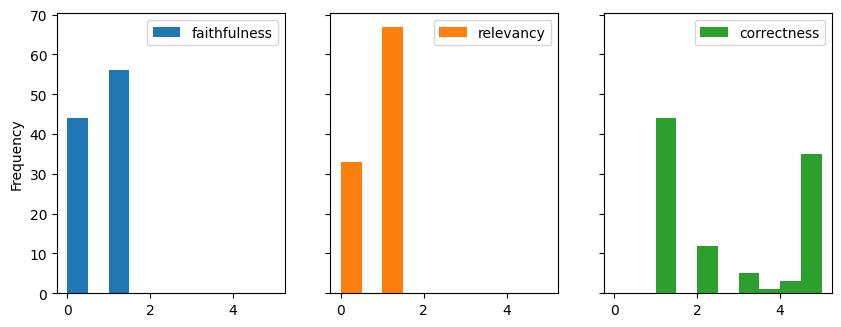

In [86]:
df_completo.plot(kind='hist', subplots=True, layout=(2, 3), figsize=(10, 8), sharey=True);

In [87]:
from sklearn.preprocessing import MinMaxScaler

df_normalizado = df_completo.copy()


# Inicializar o MinMaxScaler
scaler = MinMaxScaler()

# Normalizar a coluna 'A'
df_normalizado['correctness_normalized'] = scaler.fit_transform(df_normalizado[['correctness']])
df_normalizado = df_normalizado.drop(columns='correctness')
df_normalizado = df_normalizado.rename(columns={'correctness_normalized': 'correctness'})
df_normalizado.describe()


,faithfulness,relevancy,correctness
count,100.000000,100.000000,100.00000
mean,0.560000,0.670000,0.41500
std,0.498888,0.472582,0.43041
min,0.000000,0.000000,0.00000
25%,0.000000,0.000000,0.00000
50%,1.000000,1.000000,0.25000
75%,1.000000,1.000000,0.87500
max,1.000000,1.000000,1.00000


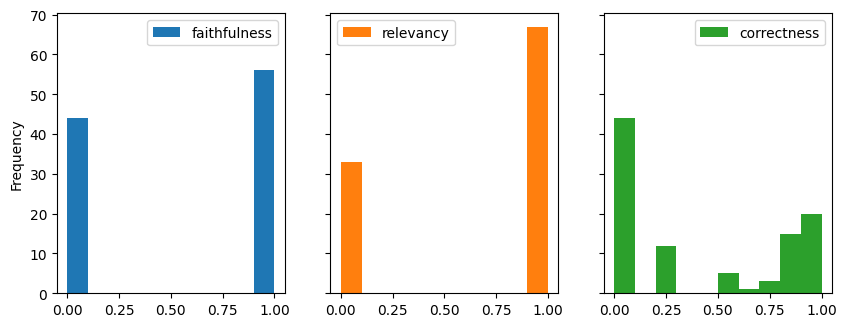

In [88]:
df_normalizado.plot(kind='hist', subplots=True, layout=(2, 3), figsize=(10, 8), sharey=True);


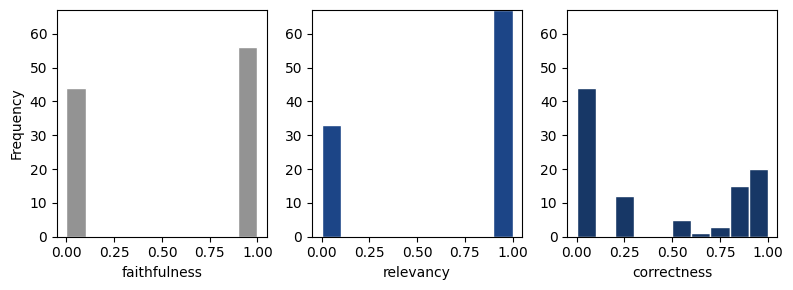

In [93]:
df_plot = df_normalizado[['faithfulness','relevancy','correctness']]

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(8, 3))

axes = axes.flatten()
colors=['#939393', '#1c4587', '#173766']

# Valor máximo entre todas as frequências
max_count = 0
for column in df_plot.columns:
    counts, _ = np.histogram(df_plot[column])
    max_count = max(max_count, counts.max())

for i, column in enumerate(df_plot.columns):

    df_plot[column].hist(ax=axes[i], # Define on which ax we're working on
                    edgecolor='white', # Color of the border
                    color=colors[i],
                    grid=False
                   )

    # Defina os limites do eixo y
    axes[i].set_ylim(0, max_count)

    # Add title and axis label
    #axes[i].set_title(f'{column} distribution')
    axes[i].set_xlabel(column)
    if i == 0:
        axes[i].set_ylabel('Frequency')

# Adjust layout
plt.tight_layout()

plt.savefig(f"{DATA_DIR}/5-evaluations/imgs/recursive-eval-results.png", dpi=1200, bbox_inches='tight')

# Show the plot
plt.show()

In [94]:
save_on_git("Salvando gráficos de avaliação do Rerank/RecursiveRetrieval")

/content/ia024-projeto-rag
From https://github.com/rsabilio/ia024-projeto-rag
 * branch            main       -> FETCH_HEAD
Already up to date.
[main 6efb13d] Salvando gráficos de avaliação do Rerank/RecursiveRetrieval
 1 file changed, 0 insertions(+), 0 deletions(-)
 create mode 100644 5-evaluations/imgs/recursive-eval-results.png
Enumerating objects: 8, done.
Counting objects: 100% (8/8), done.
Delta compression using up to 12 threads
Compressing objects: 100% (5/5), done.
Writing objects: 100% (5/5), 169.37 KiB | 11.29 MiB/s, done.
Total 5 (delta 2), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (2/2), completed with 2 local objects.
To https://github.com/rsabilio/ia024-projeto-rag
   9f695c2..6efb13d  main -> main
